In [21]:
# Note that all the code is basically taken from Gustavo Patow's WholeBrain module (https://github.com/dagush/WholeBrain)

# Load all the packages needed for analyses
import sys
import numpy as np
import scipy.io as sio
from numba import jit
import matplotlib.pyplot as plt
import pickle

# Set up Hopf as our model 
import WholeBrain.Models.supHopf as Hopf
from WholeBrain.simulate_SimOnly import Tmaxneuronal
Hopf.initialValue = 0.1
neuronalModel = Hopf

# Set up our integrator
import WholeBrain.Integrator_EulerMaruyama as myIntegrator
integrator = myIntegrator
integrator.neuronalModel = neuronalModel
integrator.verbose = False
integrator.clamping = False

# Set up the integration parameters
dt = 5e-5
# tmax is equal to the number of timepoints: 193
tmax= 193
ds = 1e-4
Tmaxneuronal = int((tmax+dt))

import WholeBrain.simulate_SimOnly as simulateBOLD
simulateBOLD.warmUp = True
simulateBOLD.integrator = integrator
simulateBOLD.warmUpFactor = 606./2000.

# Set up the code to obtain the variables we want to maximize similarity to empirical FC
import WholeBrain.Observables.FC as FC
import WholeBrain.Observables.phFCD as phFCD
import WholeBrain.Optimizers.ParmSeep as ParmSeep
ParmSeep.simulateBOLD = simulateBOLD
ParmSeep.integrator = integrator
ParmSeep.verbose = True

# set BOLD filter settings
import WholeBrain.Utils.filteredPowerSpectralDensity as filtPowSpectr
import WholeBrain.BOLDFilters as BOLDfilters

# These filters are applied in the filtPowSpectr function that we use to extract the intrinsic frequencies of each region.
# They are also applied to process the FC and swFCD and phFCD, but you can set the corresponding parameter to False later on. 0.04-0.07 Hz common to extract intrinsic frequencies
BOLDfilters.flp = 0.04
BOLDfilters.fhi = 0.07
BOLDfilters.TR = 3.0

# Get the list of names of all regions in the AAL atlas. This is needed to get the right indices, to then filter the FC
import csv
# This is a sublist of labels of the cortical regions that were included in the paper by Demirtas et al. - AAL atlas (78 regions, excluding infratentorial and deep)
with open ('/home/riccardo/ADNI_Hopf/Utils/aal_regions_included.csv', newline='') as f:
    new_reader = csv.reader(f)
    included_regions = list(new_reader)
f.close()

# Get the AAL atlas labels
import nilearn.datasets as datasets
aal = datasets.fetch_atlas_aal()
labels = np.array(aal.labels)
# create an array with the indices of each label (note that these are not the label number from the nifti image)
indices = np.array([i for i in enumerate(labels)])
SC_regions_index = np.isin(labels, included_regions)
# filter the indices that we want based on the position so to have a final SC matrix only for the regions we considered.
SC_78_regions_aal_atlas = indices[SC_regions_index]
filter_SC = np.array([int(i) for i in SC_78_regions_aal_atlas[:,0]])

# Set file path for SC matrix
x_path = '/home/riccardo/ADNI_Hopf/Utils/'
# Load structural connectivity matrix and use it as parameter in Hopf model
xfile = 'SCmatrices88healthy.mat' 
M = sio.loadmat(x_path + xfile); 
mat = M['SCmatrices']
# averaging the SC among subjects
mat0 = np.mean(mat,axis = 0)
# Filter the SC to have just the 78 regions we considered
x_mat0 = mat0[filter_SC]
new_mat0 = x_mat0.T[filter_SC]
# Prevent full synchronization of the model
SCnorm = new_mat0 * 0.2 / new_mat0.max() 
np.fill_diagonal(SCnorm,0)
print('SCnorm.shape={}'.format(new_mat0.shape))    
Hopf.setParms({'SC':SCnorm})

# Set the base_a_value to the same as previous studies
base_a_value = -0.02
# We want to warmup the timeseries before modeling
warmUp = True
warmUpFactor = 10.


SCnorm.shape=(78, 78)


In [22]:
# ------------------------------------------------
# Configure and compute Simulation for fixed a = -0.02 and fitting G to HC to find the best G
# ------------------------------------------------
# Load the list of names for all HC
list_MCI = np.load('/home/riccardo/ADNI_Hopf/Results/subject_list_timeseries_MCI.npy')
# Load the list of names for the selected HC with minimal WMH
filter_MCI = np.load('/home/riccardo/ADNI_Hopf/Results/G_fitted_to_HC-minimalWMH/subject_list_wmh_volumes_MCI_minimal.npy', allow_pickle = True).flatten()
# Get the indices of the selected HC with minimal WMH
timeseries_idx = [idx for idx, sub in enumerate(list_MCI) if sub in filter_MCI]
# Load the timeseries for all HC
timeseries_all = np.load('/home/riccardo/ADNI_Hopf/Results/timeseries_MCI.npy')
# Filter the timeseries of all HC to obtain just the selected HC with minimal WMH
timeseries = timeseries_all[timeseries_idx]
nsubjects, nNodes, Tmax = timeseries.shape
all_fMRI = {s: d for s,d in enumerate(timeseries)} 

simulateBOLD.TR = 3.  # Recording interval: 1 sample every 3 seconds
simulateBOLD.dt = 0.1 * simulateBOLD.TR / 2.
simulateBOLD.Tmax = Tmax  # This is the length, in seconds
simulateBOLD.dtt = simulateBOLD.TR  # We are not using milliseconds
simulateBOLD.t_min = 10 * simulateBOLD.TR
# simulateBOLD.recomputeTmaxneuronal() <- do not update Tmaxneuronal this way!
# simulateBOLD.warmUpFactor = 6.
simulateBOLD.Tmaxneuronal = (Tmax-1) * simulateBOLD.TR + 30
integrator.ds = simulateBOLD.TR  # record every TR millisecond

base_a_value = -0.02
# Hopf.beta = 0.01
f_diff = filtPowSpectr.filtPowSpetraMultipleSubjects(timeseries, TR=3.)  # should be baseline_group_ts .. or baseling_group[0].reshape((1,52,193))
f_diff[np.where(f_diff == 0)] = np.mean(f_diff[np.where(f_diff != 0)])  # f_diff(find(f_diff==0))=mean(f_diff(find(f_diff~=0)))

Hopf.setParms({'a': base_a_value})
Hopf.omega = 2 * np.pi * f_diff

print("ADHopf Setup done!")


filtPowSpetraMultipleSubjects: subject 0 (of 8)
filtPowSpetraMultipleSubjects: subject 1 (of 8)
filtPowSpetraMultipleSubjects: subject 2 (of 8)
filtPowSpetraMultipleSubjects: subject 3 (of 8)
filtPowSpetraMultipleSubjects: subject 4 (of 8)
filtPowSpetraMultipleSubjects: subject 5 (of 8)
filtPowSpetraMultipleSubjects: subject 6 (of 8)
filtPowSpetraMultipleSubjects: subject 7 (of 8)
ADHopf Setup done!




###################################################################
# Fitting with ParmSeep
###################################################################



*************** Starting: optim1D.distanceForAll_Parms *****************


tc(8 subjects): each entry has N=78 regions
Computing (@loadOrCompute): /home/riccardo/ADNI_Hopf/Results/G_fitted_to_HC-minimalWMH/finding_best_a_for_MCI_noWMH_new//fNeuro_emp.mat
   Processing signal 1/8 Subject: 0 (78x193) -> computed in 2.6721591120003723 seconds
   Processing signal 2/8 Subject: 1 (78x193) -> computed in 2.7145262169979105 seconds
   Processing signal 3/8 Subject: 2 (78x193) -> computed in 2.6425433789991075 seconds
   Processing signal 4/8 Subject: 3 (78x193) -> computed in 2.816400703999534 seconds
   Processing signal 5/8 Subject: 4 (78x193) -> computed in 2.703509817001759 seconds
   Processing signal 6/8 Subject: 5 (78x193) -> computed in 2.7362693540017062 seconds
   Processing signal 7/8 Subject: 6 (78x193) -> computed in 

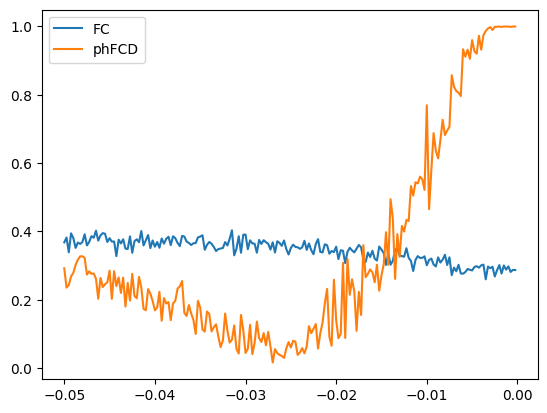

In [23]:
warmUp = True
warmUpFactor = 10.

subjectName = ''
conditionToStudy='hc'
mode = 'homogeneous'  # homogeneous/heterogeneous
# Since we haven't filtered the data in the previous step from Nilearn, we are going to filter them. 
distanceSettings = {'FC': (FC, True), 'phFCD': (phFCD, True)}

def computeSubjectSimulation():
    # integrator.neuronalModel.SC = C
    # integrator.initBookkeeping(N, Tmaxneuronal)
    if warmUp:
        currObsVars = integrator.warmUpAndSimulate(dt, Tmaxneuronal, TWarmUp=Tmaxneuronal/warmUpFactor)
    else:
        currObsVars = integrator.simulate(dt, Tmaxneuronal)
    # currObsVars = integrator.returnBookkeeping()  # curr_xn, curr_rn
    neuro_act = currObsVars[:,1,:]  # curr_rn
    return neuro_act

    
import os
outFilePath = '/home/riccardo/ADNI_Hopf/Results/G_fitted_to_HC-minimalWMH/finding_best_a_for_MCI_noWMH_new/'
if not os.path.exists(outFilePath):
        os.makedirs(outFilePath)

Hopf.setParms({'we':2.9})

As = np.round(np.arange(-0.05,0,0.00025),5)

def fittingPipeline_homogeneous(all_fMRI,
                    distanceSettings,  # This is a dictionary of {name: (distance module, apply filters bool)}
                    As):
    print("\n\n###################################################################")
    print("# Fitting with ParmSeep")
    print("###################################################################\n")
    # Now, optimize all we (G) values: determine optimal G to work with
    AParms = [{'a': a} for a in As]
    fitting = ParmSeep.distanceForAll_Parms(all_fMRI,
                                            As, 
                                            AParms,
                                            NumSimSubjects=10,
                                            distanceSettings=distanceSettings,
                                            parmLabel='finding_best_A_',
                                            outFilePath=outFilePath)

    optimal = {sd: distanceSettings[sd][0].findMinMax(fitting[sd]) for sd in distanceSettings}
    return optimal, fitting

best_parameters, fitting = fittingPipeline_homogeneous(all_fMRI=all_fMRI, distanceSettings=distanceSettings, As=As)

import matplotlib.pyplot as plt

for ds in distanceSettings:
          plt.plot(As, fitting[ds], label = ds)
          plt.legend()
          optimValDist = distanceSettings[ds][0].findMinMax(fitting[ds])
          parmPos = [a for a in np.nditer(As)][optimValDist[1]]
          print(f"# Optimal {ds} =     {optimValDist[0]} @ {np.round(parmPos, decimals=3)}")
plt.savefig(outFilePath + '/initial_exploration_plot.png')
